In [1]:
import random
import numpy as np
from LDP_Functions import LDPFL
import matplotlib.pyplot as plt


In [102]:

def generate_numbers(n, w, d, mean_tolerance=0.01):
    # Generate n random numbers with mean close to w and standard deviation d
    mean_shift = np.random.uniform(-mean_tolerance, mean_tolerance)
    numbers = np.random.normal(loc=w + mean_shift, scale=d, size=n)

    return list(numbers)

def generate_random_numbers(n, a, b):
    x = random.uniform(a, b)
    y = random.uniform(a, b)
    random_numbers = [random.uniform(min(x, y), max(x, y)) for _ in range(n)]
    return random_numbers

def generate_numbers_with_mean(n, a, b, target_mean):
    # Generate n-1 random numbers in the range [a, b]
    numbers = [target_mean] * n
    for i in range(int(n/2)):
        maxi = min(b - target_mean, target_mean - a)
        temp = random.uniform(0, maxi)
        numbers[i] += temp
        numbers[n-1-i] -= temp
    return numbers

In [98]:
a = -1
b = 1
v = 0.00003
std_dv = v ** 0.5
print("Std Dev : ", std_dv)
n = 1000
rounds = 50
c = 0
r = 1
epsilon = 8

ldp_func = LDPFL(c, r, epsilon)

Std Dev :  0.005477225575051661


In [77]:
test = [random.uniform(a, b) for _ in range(n)]

vari = 0

for q in range(100):
    freqs = []
    for i in range(rounds):
        weights = test
        noisy_weights = [ldp_func.perturb(w) for w in weights]
        temp = [0,0]
        for w in noisy_weights:
            if w > 0:
                temp[1] += 1
            else:
                temp[0] += 1
        freqs.append(temp)


    firsts = [i[0] for i in freqs]
    vari += np.var(firsts)
    # print("Variance in L's : ", np.var(firsts))

vari /= 100
print("\n\nMean var = ", vari)



Mean var =  142.2319


In [109]:
est_list = []
act_list = []
errs = []

round_history = [0 for i in range(rounds)]
value_history = [0 for i in range(rounds)]
mean_error_per_client = [0 for i in range(rounds)]


vari = 0

for qwerty in range(100):
    freqs = []
    history = []
    results = []
    errors = []
    outcomes = []
    successrate = 0
    hist_dict = {}
    actual_mean = 0
    hist_est_mean = 0
        
    # test = [random.uniform(a, b) for _ in range(n)]
    test = generate_numbers_with_mean(n, a, b, 0.2)
    # test = [0.2 for _ in range(n)]
    

    for i in range(rounds):
        
        # generate weights
        # weights = generate_numbers(n, 0, std_dv, mean_tolerance=0.001)
        # weights = generate_random_numbers(n, a, b)
        weights = test
        # weights = [random.uniform(a, b) for _ in range(n)]
        
        # apply LDP to weights
        noisy_weights = [ldp_func.perturb(w) for w in weights]
        
        temp = [0,0]
        for w in noisy_weights:
            if w > 0:
                temp[1] += 1
            else:
                temp[0] += 1
        freqs.append(temp)
        
        # These values have arrived at server. So now server computes the frequency distribution of L and R
        value1 = 0
        value2 = 0
        for w in noisy_weights:
            if w > 0:
                value1 += 1
            else:
                value2 += 1

        if tuple([value2, value1]) not in hist_dict:
            hist_dict[tuple([value2, value1])] = 0
        hist_dict[tuple([value2, value1])] += 1

        # The actual w value in the case of non-private FL
        actual_mean =  np.mean(weights)
        
        # Add current frequency values to history
        history.append([value2, value1, actual_mean])
        
        curr_est_mean = ldp_func.estimate([value2, value1])
        
        # compute global historical mean
        vals2 = [v[0] for v in history]
        vals1 = [v[1] for v in history]
        meanval2 = np.mean(vals2)
        meanval1 = np.mean(vals1)
        hist_est_mean = ldp_func.estimate([meanval2, meanval1])
        
        # Shuffle the history
        random.shuffle(history)
        
        if len(history) > 1:
            split_point = len(history) // 2

            # Split the list into two parts
            list1 = history[:split_point]
            list2 = history[split_point:]
            
            vals2 = [v[0] for v in list1]
            vals1 = [v[1] for v in list1]
            meanval2 = np.mean(vals2)
            meanval1 = np.mean(vals1)
            split_est_mean1 = ldp_func.estimate([meanval2, meanval1])
            
            vals2 = [v[0] for v in list2]
            vals1 = [v[1] for v in list2]
            meanval2 = np.mean(vals2)
            meanval1 = np.mean(vals1)
            split_est_mean2 = ldp_func.estimate([meanval2, meanval1])
            
            # the lower this value, more the confidence
            round_history[i] += abs(split_est_mean1 - split_est_mean2)/(2*r)
            
            # predicted value1
            value_history[i] += abs(hist_est_mean - actual_mean)/(2*r)
        
        mean_error = 0
        for idx in range(n):
            mean_error += abs(hist_est_mean - weights[idx])/(2*r)
        mean_error /= n
        mean_error_per_client[i] += mean_error
#         print("Noisy Weight mean : ", np.mean(noisy_weights))
#         print("Actual Weight mean : ", np.mean(weights))
#         print("Estimated mean : ", hist_est_mean)
#         print("Difference w.r.t. domain size : ", abs(hist_est_mean - np.mean(weights))/(2*r), "\n")
    
            
    act_list.append(actual_mean)
    est_list.append(hist_est_mean)
    errs.append(abs(hist_est_mean - actual_mean))
    firsts = [i[0] for i in freqs]
    vari += np.var(firsts)
    
#     for i in range(rounds):
# #       print("The difference between historical split estimated means w.r.t. domain size in round " + str(i) + " is ", round_history[i])
#         print("Round " + str(i+1) + ": Difference is ", round(value_history[i]/(qwerty+1), 4), " with confidence ", round(1/(0.01 + round_history[i]/(qwerty+1)), 4), " and mean error ", round(mean_error_per_client[i]/(qwerty+1), 4))



vari /= 100
print("Mean var = ", vari, "\n\n")
    

round_history = [elem/100 for elem in round_history]
value_history = [elem/100 for elem in value_history]
mean_error_per_client = [elem/100 for elem in mean_error_per_client]
round_history[0] = float('inf')

for i in range(rounds):
#     print("The difference between historical split estimated means w.r.t. domain size in round " + str(i) + " is ", round_history[i])
    print("Round " + str(i+1) + ": Difference is ", round(value_history[i], 4), " with confidence ", round(1/(0.01 + round_history[i]), 4), " and mean error ", round(mean_error_per_client[i], 4))

    
outstr = ""
print("\n\n")
for i in range(rounds):
    outstr += "(" + str(i+1) + ", " + str(round(value_history[i], 4)) + ") "

print(outstr)

print('\n\nThe actual mean in non-private FL : ', np.mean(act_list))
print('\nThe predicted mean after ldp-FL : ', np.mean(est_list))
print('\nError w.r.t. domain size: ', (np.mean(errs))/(2*r))

Mean var =  182.89110800000006 


Round 1: Difference is  0.0  with confidence  0.0  and mean error  0.1997
Round 2: Difference is  0.008  with confidence  39.2922  and mean error  0.1995
Round 3: Difference is  0.0065  with confidence  43.2642  and mean error  0.1995
Round 4: Difference is  0.0056  with confidence  44.9474  and mean error  0.1995
Round 5: Difference is  0.005  with confidence  51.3267  and mean error  0.1995
Round 6: Difference is  0.0049  with confidence  52.5227  and mean error  0.1995
Round 7: Difference is  0.0044  with confidence  51.0449  and mean error  0.1994
Round 8: Difference is  0.0042  with confidence  56.9149  and mean error  0.1994
Round 9: Difference is  0.0038  with confidence  56.8276  and mean error  0.1994
Round 10: Difference is  0.0036  with confidence  55.6008  and mean error  0.1994
Round 11: Difference is  0.0035  with confidence  58.8546  and mean error  0.1994
Round 12: Difference is  0.0034  with confidence  59.9419  and mean error  0.1994


In [65]:
diff = []
est_list = []
value_list = []
act_list = []

for i in range(100):
    weights = generate_numbers(n, 0, std_dv, mean_tolerance=0.01)

    noisy_weights = [ldp_func.perturb(w) for w in weights]

    value1 = 0
    value2 = 0
    for w in noisy_weights:
        if w > 0:
            value1 += 1
        else:
            value2 += 1

    actual_mean =  np.mean(weights)
    act_list.append(actual_mean)

    est_mean = ldp_func.estimate([value2, value1])
    est_list.append(est_mean)
    value_list.append([value2, value1])
    
    if len(value_list) > 1:
        
    
    diff.append(abs(actual_mean - est_mean))

range_of_occurrence = 0.2

# print('The average difference in estimation per range of occurence : ', np.mean(diff)/range_of_occurrence)

print('The actual mean in non-private FL : ', np.mean(act_list))
print('\nThe predicted mean after ldp-FL : ', np.mean(est_list))
print('\nError w.r.t. domain size: ', (np.mean(diff))/1.5)

The actual mean in non-private FL :  -0.0004580449063109869

The predicted mean after ldp-FL :  -0.0010274559954737306

Error w.r.t. domain size:  0.013706925414319816


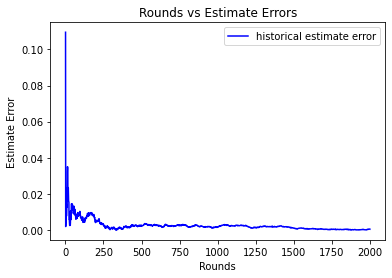

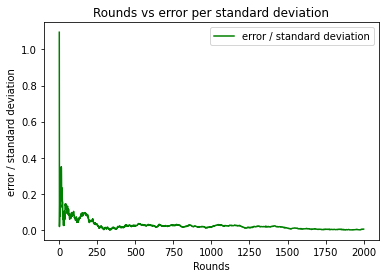

In [52]:
# %matplotlib inline

x = range(1, rounds+1)
y1 = [v[0] for v in errors]
y2 = [v[1] for v in errors]

plt.figure(1)

# plot the data
# plt.plot(x, y1, color='red', label='current estimate error')
plt.plot(x, y2, color='blue', label='historical estimate error')

# set plot title and labels
plt.title('Rounds vs Estimate Errors')
plt.xlabel('Rounds')
plt.ylabel('Estimate Error')

# set legend and show plot
plt.legend()

y3 = outcomes

plt.figure(2)

# plot the data
plt.plot(x, y3, color='green', label='error / standard deviation')

# set plot title and labels
plt.title('Rounds vs error per standard deviation')
plt.xlabel('Rounds')
plt.ylabel('error / standard deviation')

# set legend and show plot
plt.legend()


plt.show()